In [1]:
import sys
try:
    if path:
        raise Exception('changed')
except:
    path = True
    sys.path.append('../')


import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from src.bos_model_polynomials import compute_polynomials
from src.compute_u import compute_u as compute_polynomials_god


In [2]:
def compute_derivative_polynomials(p: np.ndarray) -> np.ndarray:
    """
    Compute the derivative of the polynomials represented by the coefficients in p.

    P(x) = p[0] * x^(n-1) + p[1] * x^(n-2) + ... + p[n-1]

    Parameters
    ----------
    p : np.ndarray
        Coefficients of the polynomial.
    
    Returns
    -------
    np.ndarray
        Coefficients of the derivative of the polynomial.
    """
    n = len(p)
    dp = np.zeros(n-1)
    for i in range(n-1):
        dp[i] = p[i] * (n-1-i)
    return dp

50.0 + 100.0·x - 50.0·x² + 1.0·x³
100.0 - 100.0·x + 3.0·x²
True
5000.0 + 5000.0·x - 14850.0·x² + 5400.0·x³ - 250.0·x⁴ + 3.0·x⁵


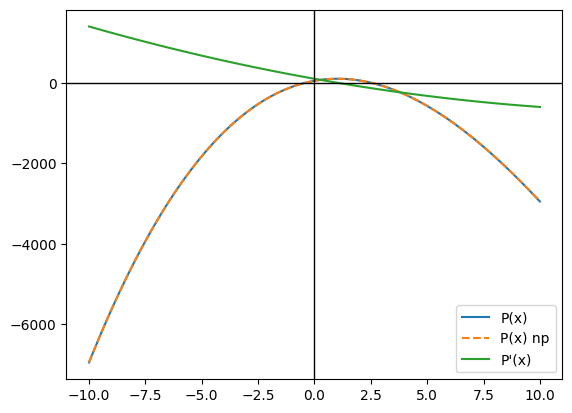

In [3]:
# check the function by plotting the polynomials and their derivatives

p = np.array([1, -50, 100, 50]) 
pnp = np.polynomial.Polynomial(p[::-1])
print(pnp)
dp = compute_derivative_polynomials(p)
dpnp = pnp.deriv()
print(dpnp)
print(np.polynomial.Polynomial(dp[::-1]) == dpnp)
x = np.linspace(-10, 10, 100)

print(pnp * dpnp)

plt.plot(x, np.polyval(p, x), label='P(x)')
plt.plot(x, pnp(x), label='P(x) np', linestyle='--')
plt.plot(x, np.polyval(dp, x), label="P'(x)")
# plot the 0 lines
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.legend()

In [4]:
def get_second_log_derivative_numerator(p: np.ndarray) -> np.polynomial.Polynomial:
    """
    Compute the numerator of the second derivative of the log of the polynomials represented by the coefficients in p.

    P(x) = p[0] * x^(n-1) + p[1] * x^(n-2) + ... + p[n-1]

    Returns the coefficients of the numerator of the second derivative of the log of the polynomial.
    (log P)'' = P'' P - (P')^2

    Parameters
    ----------
    p : np.ndarray
        Coefficients of the polynomial.
    
    Returns
    -------
    np.ndarray
        Coefficients of the numerator of the second derivative of the log of the polynomial.
    """
    p = np.polynomial.Polynomial(p[::-1])
    dp = p.deriv()
    ddp = dp.deriv()
    return ddp * p - dp**2

In [5]:
def check_negativity(p: np.polynomial.Polynomial) -> bool:
    """
    Check if the polynomial represented by the coefficients in p is negative (<= 0) for all x in [0, 1].

    Parameters
    ----------
    p : np.ndarray
        Coefficients of the polynomial.
    
    Returns
    -------
    bool
        True if the polynomial is positive for all x, False otherwise.
    """
    return np.all(p(np.linspace(0, 1, 10_000)) <= 0)

In [6]:
def check_formal_negativity(p: np.polynomial.Polynomial) -> bool:
    """
    Check if the polynomial represented by the coefficients in p is negative (<= 0) for all x in [0, 1].

    Parameters
    ----------
    p : np.ndarray
        Coefficients of the polynomial.
    
    Returns
    -------
    bool
        True if all coefficients are negative (<= 0), False otherwise.
    """
    if np.all(p.coef <= 0):
        return True
    else:
        if p.coef[0] > 0:
            return False
        else:
            # if not p.coef[p.coef > 0].sum() <= -p.coef[0]:
            #     print(p.coef[p.coef > 0].sum(),  -p.coef[0])
            return p.coef[p.coef > 0].sum() <= -p.coef[0] 




In [7]:
p = np.polynomial.Polynomial([1, -50, 100, 50])
print(p)
print(p.coef)

1.0 - 50.0·x + 100.0·x² + 50.0·x³
[  1. -50. 100.  50.]


In [8]:
def check_log_concavity(p: np.ndarray) -> bool:
    """
    Check if the log of the polynomial represented by the coefficients in p is concave.

    Parameters
    ----------
    p : np.ndarray
        Coefficients of the polynomial.
    
    Returns
    -------
    bool
        True if the log of the polynomial is concave, False otherwise.
    """
    p_pos = get_second_log_derivative_numerator(p)
    return check_formal_negativity(p_pos) or check_negativity(p_pos)
    # return check_formal_negativity(get_second_log_derivative_numerator(p))

In [9]:
for M in tqdm(range(1, 150)):
    u = compute_polynomials(M)
    for x in range(M):
        for mu in range(M):
            assert check_log_concavity(u[x, mu]), f'Failed for {M=} {x=}, mu={mu}'

  0%|          | 0/149 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [78]:
M = 5
u = compute_polynomials(M)

In [81]:
for x in range(M):
    for mu in range(M):
        p = get_second_log_derivative_numerator(u[x, mu])
        print(p)
        print(check_formal_negativity(p))
        assert check_log_concavity(u[x, mu]), f'Failed for {M=} {x=}, mu={mu}'

-0.33550278 - 0.18922083·x - 0.05006979·x² - 0.0056463·x³ -
0.00031169·x⁴ - (7.87037037e-06)·x⁵ - (7.71604938e-08)·x⁶
True
-0.08758056 - 0.02741389·x - 0.09270386·x² - 0.03600679·x³ -
0.00593534·x⁴ - 0.00035185·x⁵ - (7.71604938e-06)·x⁶
True
-0.06583611 + 0.01445417·x - 0.02683646·x² + 0.01775648·x³ -
0.00244363·x⁴ - 0.00103704·x⁵ - (9.45216049e-05)·x⁶
True
-0.05424722 + 0.04625648·x - 0.01672238·x² + 0.00719877·x³ -
0.00500756·x⁴ + 0.00168981·x⁵ - 0.0001929·x⁶
0.05514506172839505 0.054247222222222224
False
0.05514506172839505 0.054247222222222224


AssertionError: Failed for M=5 x=0, mu=3

0.2 + 0.63166667·x + 0.15875·x² + 0.00944444·x³ + 0.00013889·x⁴
0.2 - 0.08166667·x - 0.10958333·x² - 0.00861111·x³ - 0.00013889·x⁴
0.2 - 0.22666667·x + 0.01416667·x² + 0.01222222·x³ + 0.00027778·x⁴
0.2 - 0.30666667·x + 0.1175·x² - 0.01·x³ - 0.00083333·x⁴
0.2 - 0.35666667·x + 0.19666667·x² - 0.04333333·x³ + 0.00333333·x⁴
0.2 + 0.055·x - 0.21138889·x² - 0.04222222·x³ - 0.00138889·x⁴
0.2 + 0.56666667·x + 0.21055556·x² + 0.02222222·x³ + 0.00055556·x⁴
0.2 - 0.055·x - 0.11930556·x² - 0.025·x³ - 0.00069444·x⁴
0.2 - 0.165·x - 0.06347222·x² + 0.02666667·x³ + 0.00180556·x⁴
0.2 - 0.22833333·x - 0.00527778·x² + 0.04055556·x³ - 0.00694444·x⁴
0.2 - 0.10166667·x - 0.13875·x² + 0.03555556·x³ + 0.00486111·x⁴
0.2 - 0.01333333·x - 0.155·x² - 0.03027778·x³ - 0.00138889·x⁴
0.2 + 0.56333333·x + 0.21027778·x² + 0.02555556·x³ + 0.00083333·x⁴
0.2 - 0.01333333·x - 0.155·x² - 0.03027778·x³ - 0.00138889·x⁴
0.2 - 0.10166667·x - 0.13875·x² + 0.03555556·x³ + 0.00486111·x⁴
0.2 - 0.22833333·x - 0.00527778·x² + 0.04055

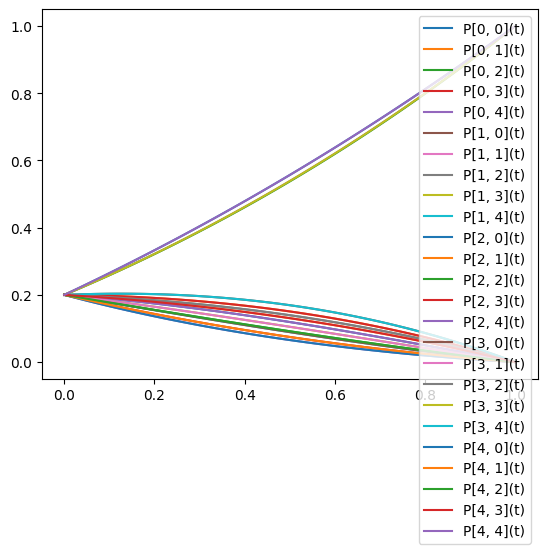

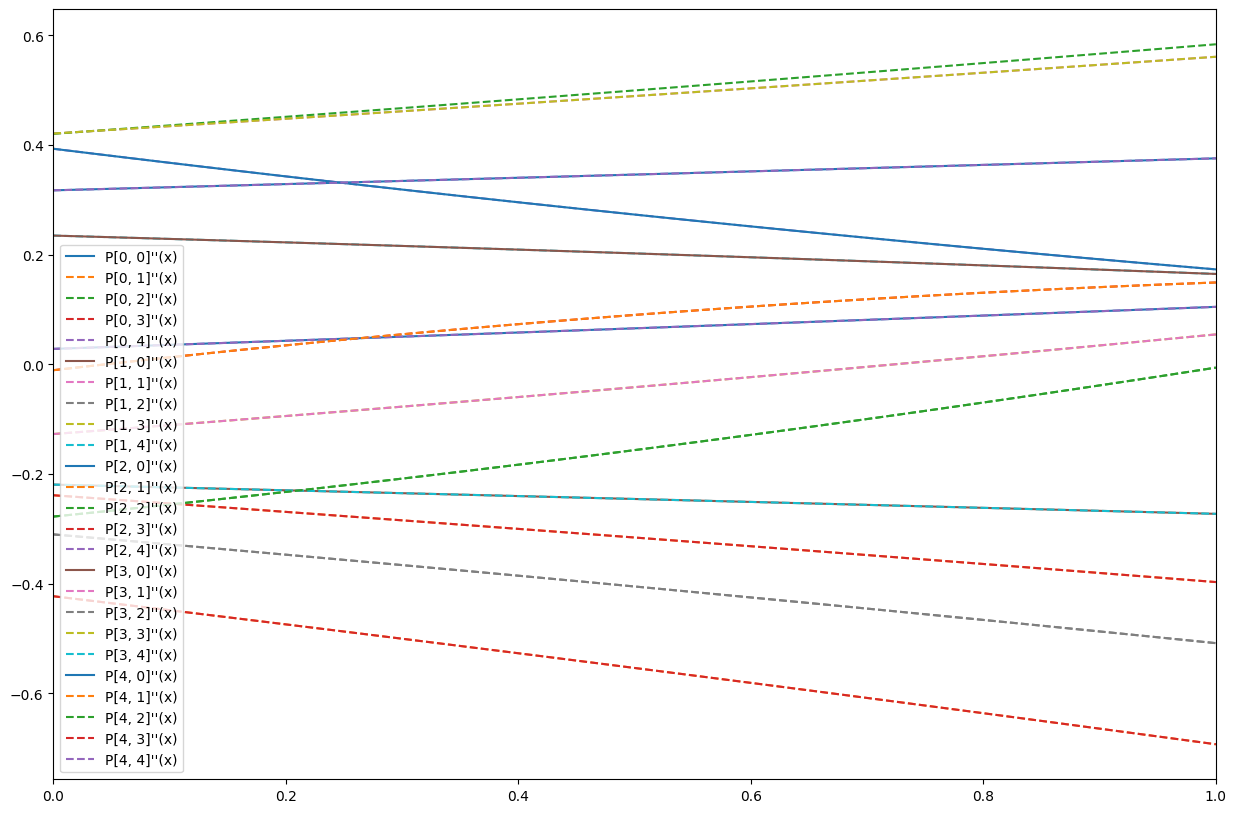

In [21]:
M = 5
u = compute_polynomials(M)
xs = np.linspace(0, 1, 100)

for x in range(M):
    for mu in range(M):
        coeffs = u[mu, x][::-1]
        p = np.polynomial.Polynomial(coeffs)
        print(p)

        plt.plot(xs, p(xs), label=f'P[{x}, {mu}](t)')
        # plt.xlim(0, 1)
plt.legend()
plt.show()

plt.figure(figsize=(15, 10))
for x in range(M):
    for mu in range(M):
        coeffs = u[x, mu][::-1]
        p = np.polynomial.Polynomial(coeffs)
        plt.plot(xs, p.deriv(2)(xs), label=f"P[{x}, {mu}]''(x)", linestyle='--' if mu > 0 else '-')
        plt.xlim(0, 1)
plt.legend()


In [30]:
def check_bi_monocity(seq: np.ndarray) -> bool:
    """
    Check if the sequence is bi-monotonic ie the sequence is
    increasing and then decreasing (pssibly with an empty increasing or decreasing part).

    Parameters
    ----------
    seq : np.ndarray
        Sequence to check.
    
    Returns
    -------
    bool
        True if the sequence is bi-monotonic, False otherwise.
    """
    diff = np.diff(seq)
    sign = 0
    changed = False
    for d in diff:
        if sign * d < 0:
            if changed:
                return False
            changed = True
        sign = np.sign(d)
    return True
    

In [65]:
for M in tqdm(range(1, 40)):
    u = compute_polynomials_god(M)

    eps = 1e-5
    xs = np.linspace(eps, 1 - eps, 100)
    for x in range(M):
        for mu in range(M):
            f = lambda t: np.log(
                np.polynomial.Polynomial(u[x, mu])((1 - t)/t) * t ** (M - 1)
                )
            # plt.plot(xs, f(xs), label=f'log P({x}, {mu})')
            bi_monotonic = check_bi_monocity(f(xs))
            assert bi_monotonic, f'Failed for {M=} {x=}, mu={mu}'

  0%|          | 0/39 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [66]:
M = 24
u = compute_polynomials_god(M)

    

KeyboardInterrupt: 

In [ ]:
eps = 1e-5
xs = np.linspace(eps, 1 - eps, 100)
for x in range(M):
    for mu in range(M):
        f = lambda t: np.log(
            np.polynomial.Polynomial(u[x, mu])((1 - t)/t) * t ** (M - 1)
            )
        # plt.plot(xs, f(xs), label=f'log P({x}, {mu})')
        bi_monotonic = check_bi_monocity(f(xs))
        assert bi_monotonic, f'Failed for {M=} {x=}, mu={mu}'

Failed for M=10 i=0, mu=4 u=array([0.  , 0.84, 0.08, 0.2 , 0.37, 0.33, 0.43, 0.94, 0.14, 0.56])
Failed for M=10 i=6, mu=4 u=array([0.  , 0.8 , 0.32, 0.45, 0.44, 0.37, 0.5 , 0.91, 0.97, 0.4 ])
Failed for M=10 i=8, mu=4 u=array([0.  , 0.13, 0.73, 0.63, 0.76, 0.74, 0.45, 0.26, 0.33, 0.56])


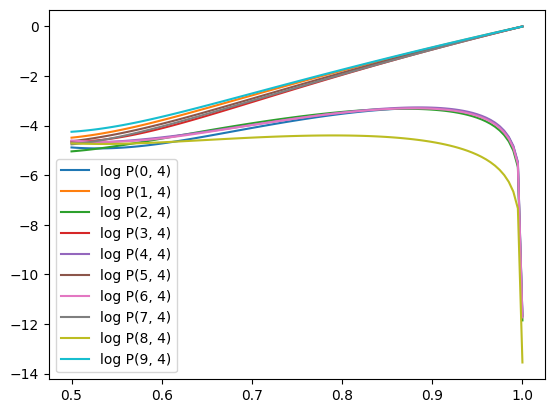

In [59]:
M = 10
# u = compute_polynomials_god(5)

eps = 1e-5
xs = np.linspace(eps + 1/2, 1 - eps, 100)
for i in range(10):
    u = np.random.randint(1, 100, size=M) / 100
    u[0] = i % 2
    f = lambda t: np.log(
        np.polynomial.Polynomial(u)((1 - t)/t) * t ** (M - 1)
        )
    plt.plot(xs, f(xs), label=f'log P({i}, {mu})')
    bi_monotonic = check_bi_monocity(f(xs))
    if not bi_monotonic:
        print(f'Failed for {M=} {i=}, mu={mu} {u=}')
plt.legend()

Failed for M=10, mu=4 u=array([0.  , 0.84, 0.08, 0.2 , 0.37, 0.33, 0.43, 0.94, 0.14, 0.56])


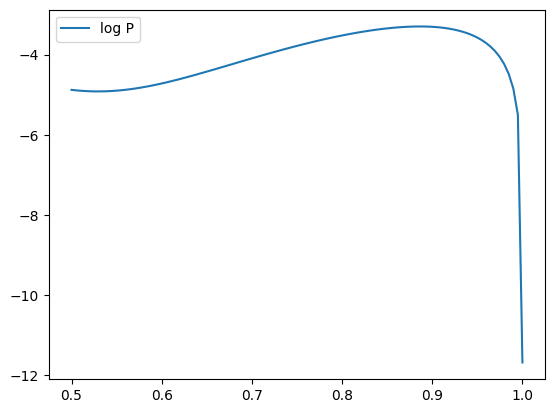

In [61]:
M = 10
# u = compute_polynomials_god(5)

eps = 1e-5
xs = np.linspace(eps + 1/2, 1 - eps, 100)

u=np.array([0.  , 0.84, 0.08, 0.2 , 0.37, 0.33, 0.43, 0.94, 0.14, 0.56])
f = lambda t: np.log(
    np.polynomial.Polynomial(u)((1 - t)/t) * t ** (M - 1)
    )
plt.plot(xs, f(xs), label=f'log P')
bi_monotonic = check_bi_monocity(f(xs))

if not bi_monotonic:
    print(f'Failed for {M=}, mu={mu} {u=}')
plt.legend()

In [40]:
M = 5
u = compute_polynomials_god(5)
u[:, :, 0]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [46]:
lp(x)

array([-4.51003086e-05, -7.55996929e-05, -1.18936068e-04, -1.78027476e-04,
       -2.56126286e-04, -3.56829062e-04, -4.84086559e-04, -6.42213837e-04,
       -8.35900501e-04, -1.07022106e-03, -1.35064539e-03, -1.68304940e-03,
       -2.07372567e-03, -2.52939438e-03, -3.05721422e-03, -3.66479355e-03,
       -4.36020155e-03, -5.15197960e-03, -6.04915273e-03, -7.06124120e-03,
       -8.19827222e-03, -9.47079176e-03, -1.08898765e-02, -1.24671460e-02,
       -1.42147746e-02, -1.61455041e-02, -1.82726562e-02, -2.06101445e-02,
       -2.31724880e-02, -2.59748233e-02, -2.90329176e-02, -3.23631822e-02,
       -3.59826852e-02, -3.99091650e-02, -4.41610434e-02, -4.87574398e-02,
       -5.37181844e-02, -5.90638318e-02, -6.48156755e-02, -7.09957614e-02,
       -7.76269022e-02, -8.47326917e-02, -9.23375191e-02, -1.00466583e-01,
       -1.09145909e-01, -1.18402358e-01, -1.28263648e-01, -1.38758365e-01,
       -1.49915982e-01, -1.61766868e-01, -1.74342309e-01, -1.87674521e-01,
       -2.01796666e-01, -

In [1]:
import sympy as sp

In [3]:
x = sp.symbols('x', real=True, positive=True)
d = sp.symbols('d', integer=True, positive=True)
i = sp.symbols('i', integer=True, positive=True)
j = sp.symbols('j', integer=True, positive=True)

cd = ((1 - x)  / x ) ** d
cd_ = sp.simplify(sp.diff(cd, x))
my_cd_ = -d * x ** (-2) * ((1 - x)  / x ) ** (d - 1)
cd__ = sp.simplify(sp.diff(cd, x, 2))
my_cd__ = d  * x ** (-4) * (1 - 2 * x + d) * ((1 - x)  / x ) ** (d - 2)

dlogcd = sp.simplify(sp.diff(sp.log(cd), x, 2))
my_dlogcd = -d * x ** (-4) * (2* x - 1) * ((1 - x)  / x ) ** (2 *  d - 2) / (  ((1 - x)  / x ) ** (2 *  d ) )

cd

((1 - x)/x)**d

In [27]:
x = sp.symbols('x', real=True, positive=True)
d = sp.symbols('d', integer=True, positive=True)
m = sp.symbols('m', integer=True, positive=True)

cd = (1 - x) ** d * x ** (m - 1 - d)
cd_ = sp.simplify(sp.diff(cd, x))
my_cd_ = ((1 - m) * x + m - 1 - d) * (1 - x) ** (d - 1) * x ** (m - 2 - d)

cd

x**(-d + m - 1)*(1 - x)**d

In [29]:
sp.simplify(cd_ - my_cd_)

x**(-d + m - 2)*((-1)**d*(x - 1)**(d - 1)*(d + m*x - m - x + 1) + (1 - x)**(d - 1)*(d - m + x*(m - 1) + 1))

In [89]:
cd_

(-1)**d*d*x**(-d - 1)*(x - 1)**(d - 1)

In [90]:
cd__

(-1)**(d + 1)*d*x**(-d - 2)*(x - 1)**(d - 2)*(-d + 2*x - 1)

In [91]:
sp.simplify(cd_ - sp.simplify(my_cd_))


d*x**(-d - 1)*((-1)**d*(x - 1)**(d - 1) + (1 - x)**(d - 1))

In [92]:
cd__

(-1)**(d + 1)*d*x**(-d - 2)*(x - 1)**(d - 2)*(-d + 2*x - 1)

In [93]:
sp.simplify(cd__ - sp.simplify(my_cd__))

d*x**(-d - 2)*((-1)**d*(x - 1)**(d - 2) - (1 - x)**(d - 2))*(d - 2*x + 1)

In [94]:
dlogcd

-d*(2*x - 1)/(x**2*(x - 1)**2)

In [97]:
sp.simplify(dlogcd - sp.simplify(my_dlogcd))

0

In [62]:
# derivative of cd

for d in range(100):

    cd = ((1 - x)  / x ) ** d

    cd_ = sp.diff(cd, x)
    my_cd_ = -d * x ** (-2) * ((1 - x)  / x ) ** (d - 1)

    assert sp.simplify(cd_ - my_cd_ ) == 0, f'Failed for {d=} {cd_=} {my_cd_=}'

    cd__ = sp.diff(cd, x, 2)
    my_cd__ = d * x ** (-4) * (1 - 2 * x + d) * ((1 - x)  / x ) ** (d - 2)

    assert sp.simplify(cd__ - my_cd__ ) == 0, f'Failed for {d=} {cd__=} {my_cd__=}'

In [39]:
sp.diff(cd, x, 2)

d*(-(x - 1)/x)**d*(1 - (x - 1)/x)*(d*(1 - (x - 1)/x)/(x - 1) - 1/(x - 1) - 1/x)/(x - 1)

In [ ]:
x = sp.symbols('x', real=True, positive=True)
d = sp.symbols('d', integer=True, positive=True)
i = sp.symbols('i', integer=True, positive=True)
j = sp.symbols('j', integer=True, positive=True)

cd = ((1 - x)  / x ) ** d
cd_ = sp.simplify(sp.diff(cd, x))
my_cd_ = -d * x ** (-2) * ((1 - x)  / x ) ** (d - 1)
cd__ = sp.simplify(sp.diff(cd, x, 2))
my_cd__ = d  * x ** (-4) * (1 - 2 * x + d) * ((1 - x)  / x ) ** (d - 2)

dlogcd = sp.simplify(sp.diff(sp.log(cd), x, 2))
my_dlogcd = -d * x ** (-4) * (2* x - 1) * ((1 - x)  / x ) ** (2 *  d - 2) / (  ((1 - x)  / x ) ** (2 *  d ) )

cd

((1 - x)/x)**d

In [115]:
i = 8
j = 7

ci = ((1 - x)  / x ) ** i
cj = ((1 - x)  / x ) ** j
ci_ = sp.simplify(sp.diff(ci, x))
cj_ = sp.simplify(sp.diff(cj, x))
ci__ = sp.simplify(sp.diff(ci, x, 2))
cj__ = sp.simplify(sp.diff(cj, x, 2))

In [116]:
cross = sp.simplify(2 * ci_ * cj_ - ci * cj__ - ci__ * cj)
cross

(x - 1)**13*(98*x**2 - 226*x*(x - 1) + 128*(x - 1)**2 - 112)/x**17

In [117]:
my_cross = x ** (-4) * ((1 - x)  / x ) ** (i + j - 2) * (-(j - i) ** 2 - (i + j) * (1 - 2 * x))
my_cross

(1 - x)**13*(30*x - 16)/x**17

In [118]:
sp.simplify(cross - my_cross)

0

In [119]:
for i in range(50):
    for j in range(50):

        ci = ((1 - x)  / x ) ** i
        cj = ((1 - x)  / x ) ** j
        ci_ = sp.simplify(sp.diff(ci, x))
        cj_ = sp.simplify(sp.diff(cj, x))
        ci__ = sp.simplify(sp.diff(ci, x, 2))
        cj__ = sp.simplify(sp.diff(cj, x, 2))

        cross = sp.simplify(2 * ci_ * cj_ - ci * cj__ - ci__ * cj)
        my_cross = x ** (-4) * ((1 - x)  / x ) ** (i + j - 2) * (-(j - i) ** 2 - (i + j) * (1 - 2 * x))

        assert sp.simplify(cross - my_cross) == 0, f'Failed for {i=} {j=} {cross=} {my_cross=}'

KeyboardInterrupt: 

In [15]:
x = sp.symbols('x', real=True, positive=True)
u = sp.symbols('u:7', real=True, sequence=True, positive=True)

c0 = 1
c1 = (1 - x) / x
c2 = ((1 - x) / x) ** 2
c3 = ((1 - x) / x) ** 3
c4 = ((1 - x) / x) ** 4
c5 = ((1 - x) / x) ** 5
c6 = ((1 - x) / x) ** 6

s = u[0] * c0 + u[1] * c1 + u[2] * c2 + u[3] * c3 + u[4] * c4 + u[5] * c5 + u[6] * c6

s = u[0] * c0 + u[1] * c1
s

u0 + u1*(1 - x)/x

In [16]:
dlog = sp.simplify(sp.diff(sp.log(s), x, 2))
dlog

-u1*(-2*u0*x + 2*u1*(x - 1) + u1)/(x**2*(u0*x - u1*(x - 1))**2)

In [17]:
s_ = sp.simplify(sp.diff(s, x))
s__ = sp.simplify(sp.diff(s, x, 2))
dlog_ = sp.simplify(s_ ** 2 - s * s__)
dlog_ * x **  4

u1*(-2*u0*x + 2*u1*x - u1)